**Introduction**
This notebook explores predictors of self‑reported heart attack status in the 2022 survey data. We load `heart_2022_with_nans.csv`, clean and preprocess it, then train tree‑based models (Random Forest, XGBoost). Finally, we tune hyperparameters and discuss model performance.



In [29]:
# IMPORTS:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    accuracy_score,
    classification_report,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
    make_scorer
)



**Early Encoding and Training**

In [15]:

df = pd.read_csv('heart_2022_no_nans.csv')

# Print columns
print("Columns in dataset:", df.columns.tolist())

# Target "HadHeartAttack"
target_col = 'HadHeartAttack'
y = df[target_col].map({'Yes': 1, 'No': 0})
X = df.drop(columns=[target_col])


# Encode categoricals
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_ohe = pd.DataFrame(
    ohe.fit_transform(X[cat_cols]),
    columns=ohe.get_feature_names_out(cat_cols),
    index=X.index
)
X = pd.concat([X[num_cols], X_ohe], axis=1)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=100
)

print('Done')

Columns in dataset: ['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities', 'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory', 'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']


C:\Users\kwcoo\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Done


**Exploratory Data Analysis**

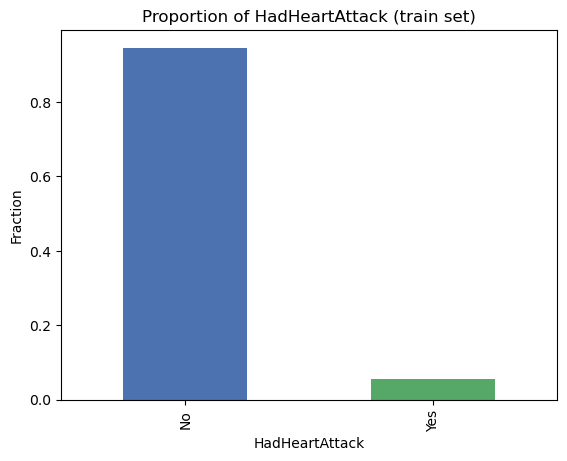

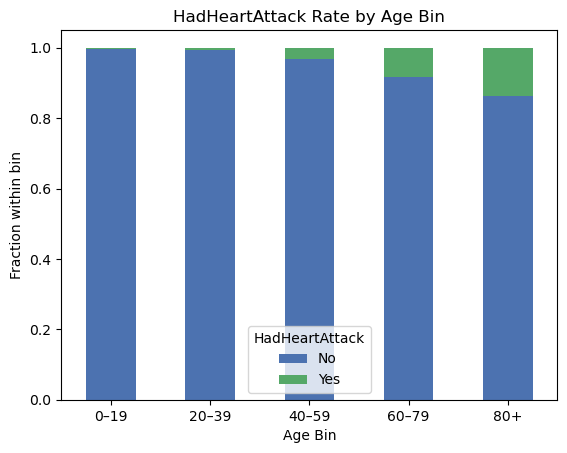

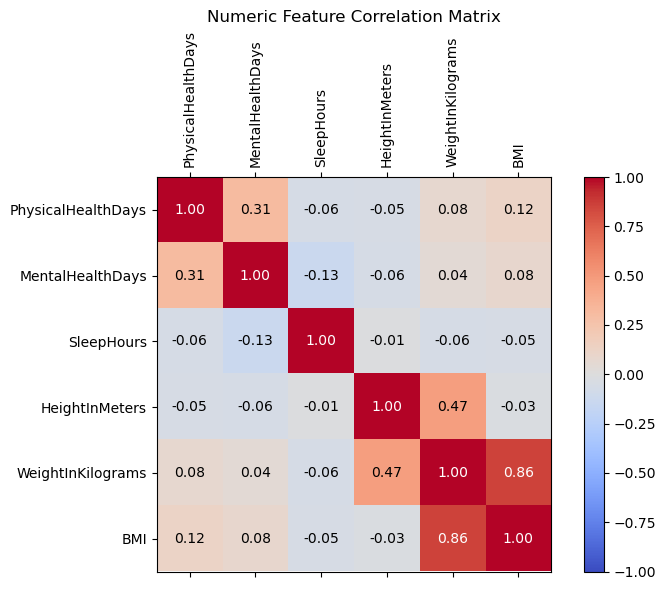

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


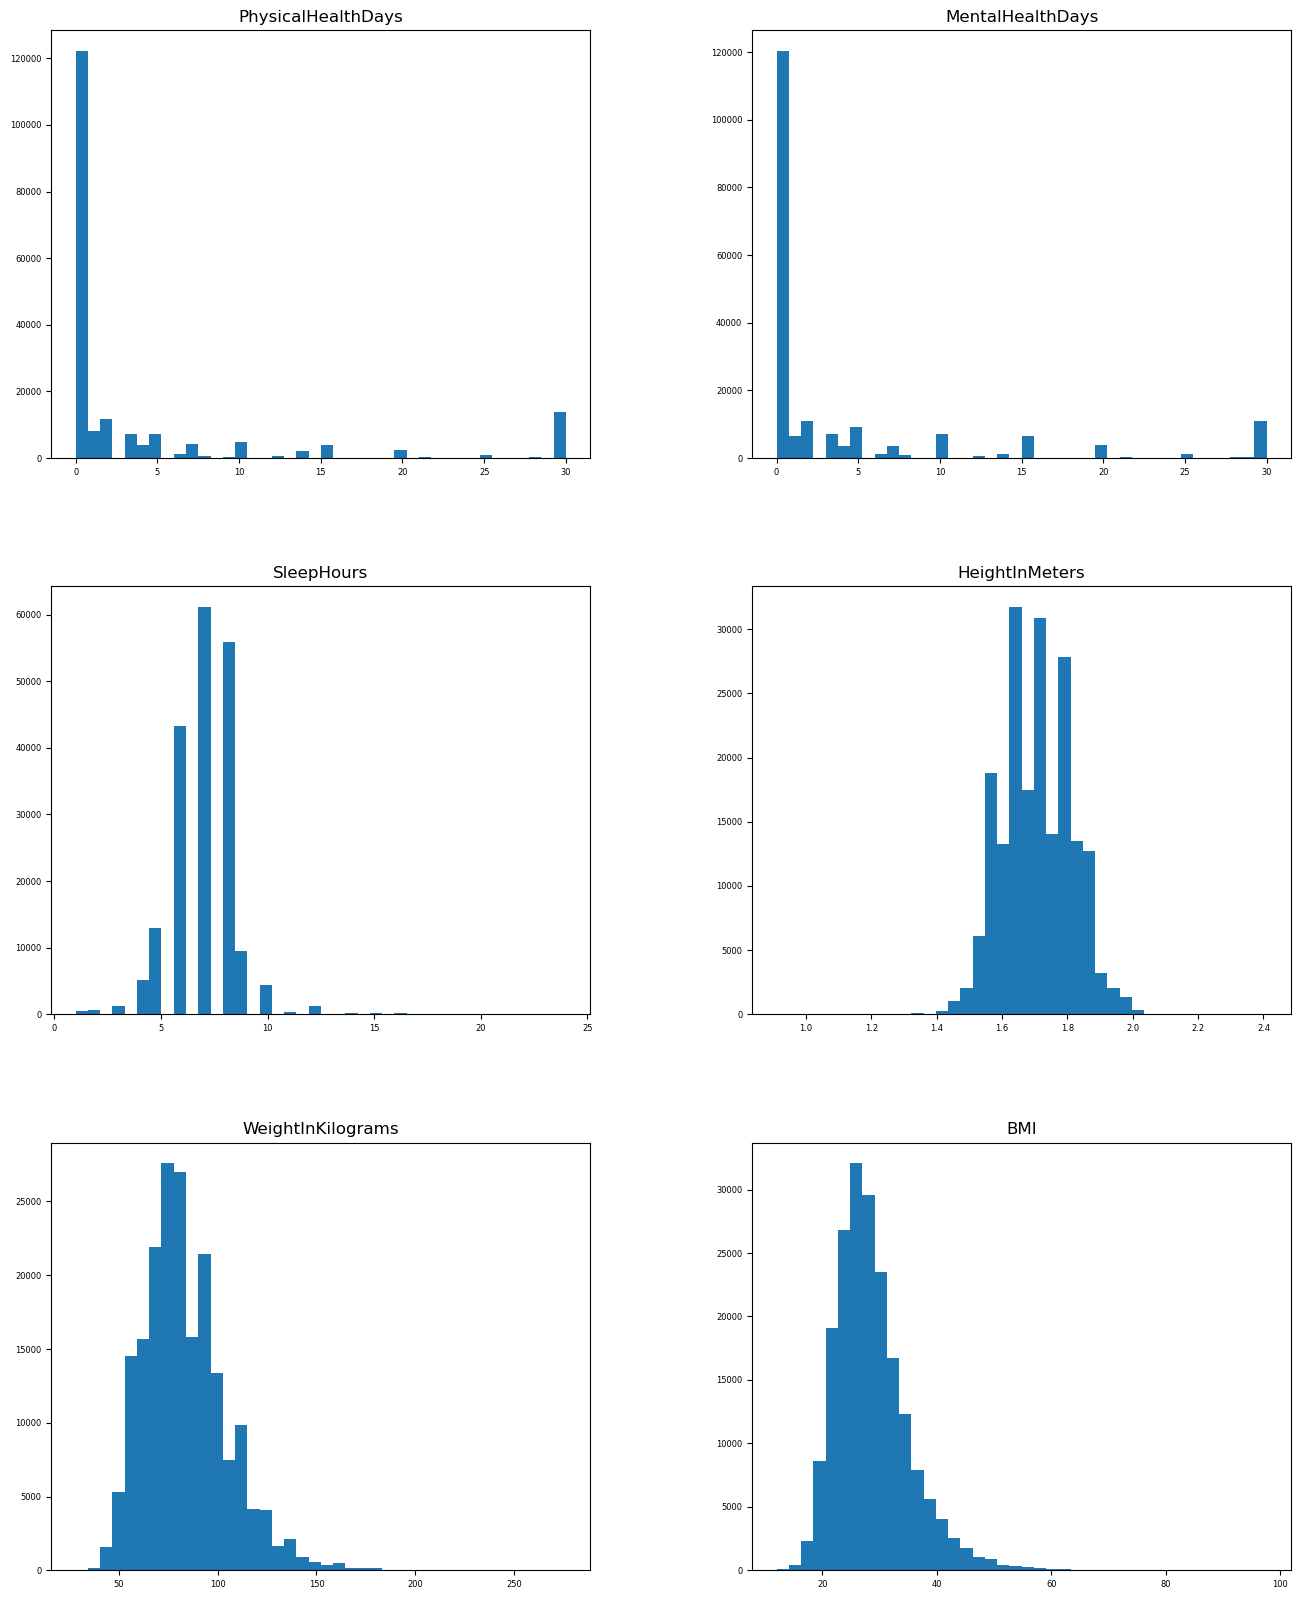

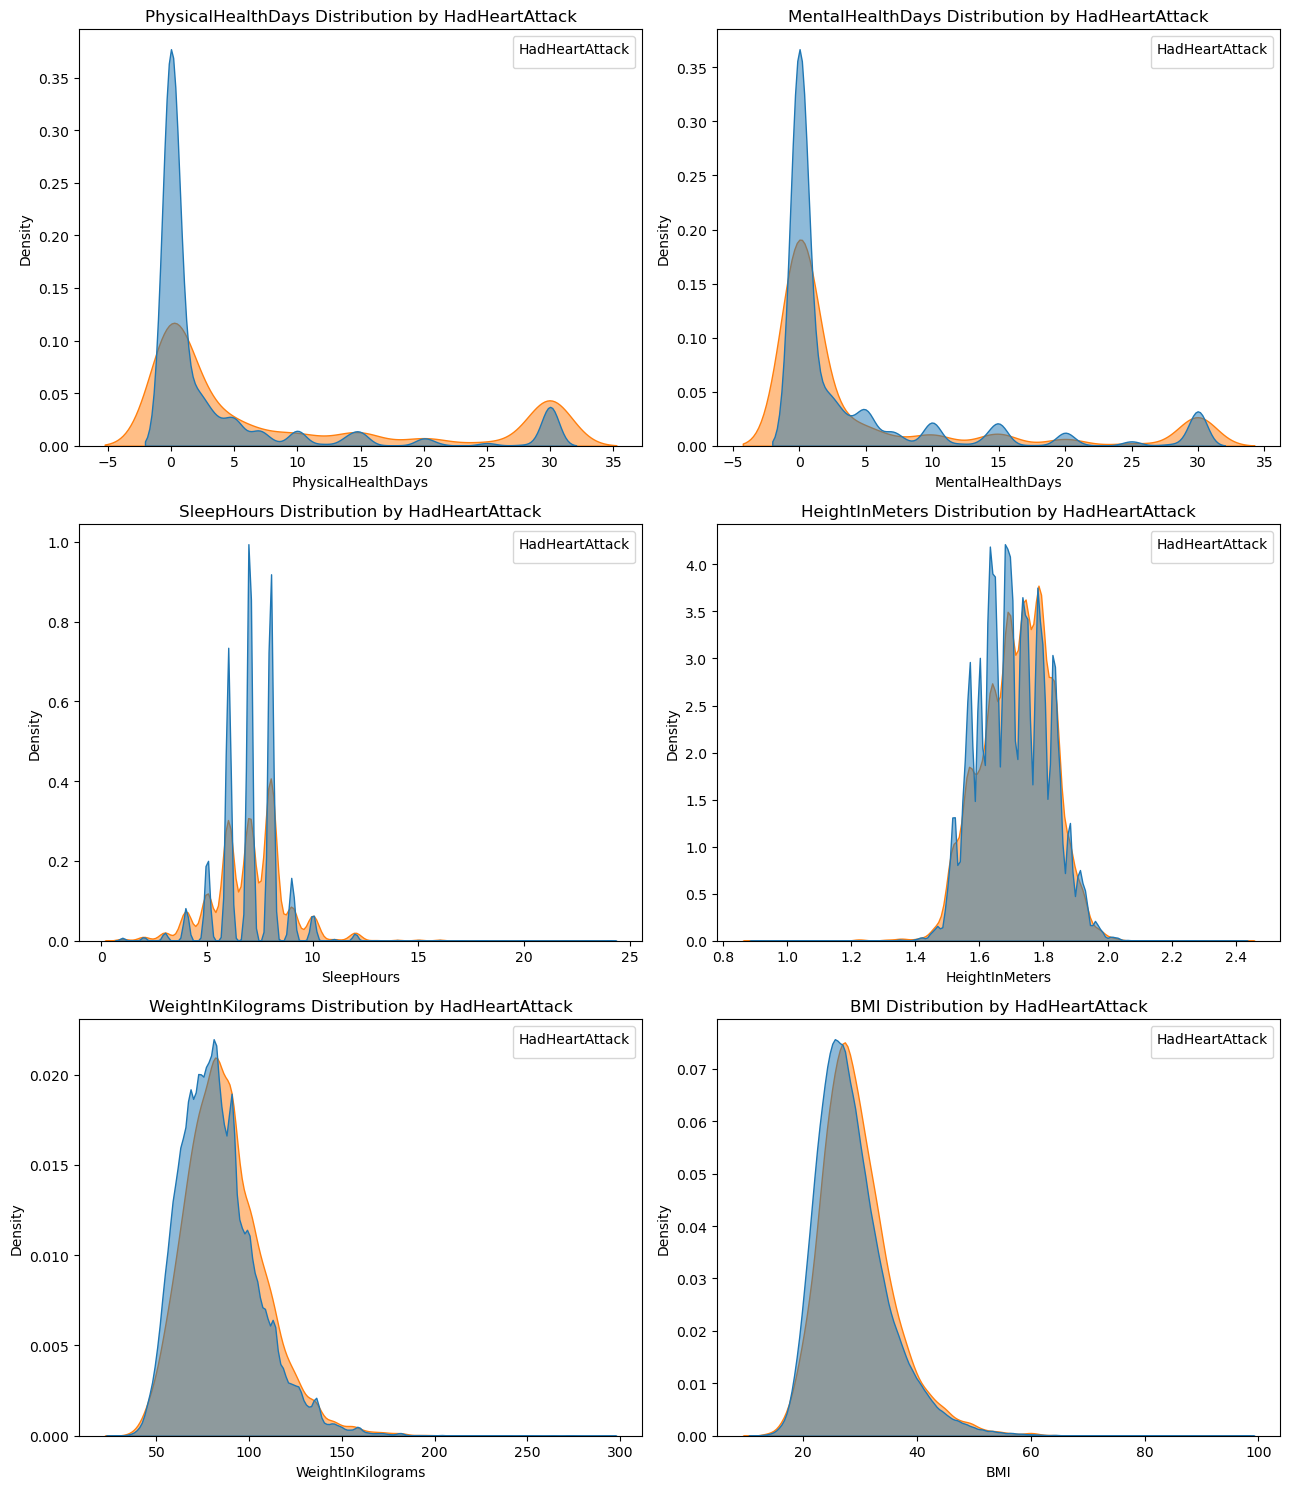

In [13]:


# heart attack dist 
hf = y_train.value_counts(normalize=True).rename(index={0:'No', 1:'Yes'})
ax = hf.plot.bar(
    title='Proportion of HadHeartAttack (train set)',
    ylabel='Fraction',
    color=['#4C72B0','#55A868']
)
ax.set_xlabel('HadHeartAttack')
plt.show()


# Age bins
#    e.g. "Age 65 to 69" → 65
df['AgeLow'] = df['AgeCategory'].str.extract(r'(\d+)').astype(int)

bins  = [0,20,40,60,80,200]
labels = ['0–19','20–39','40–59','60–79','80+']
df['AgeBin'] = pd.cut(df['AgeLow'], bins=bins, labels=labels, right=False)

age_ct = pd.crosstab(df['AgeBin'], df['HadHeartAttack'])
age_ct.div(age_ct.sum(axis=1), axis=0).plot.bar(
    stacked=True,
    color=['#4C72B0','#55A868'],
    title='HadHeartAttack Rate by Age Bin'
)
plt.ylabel('Fraction within bin')
plt.xlabel('Age Bin')
plt.xticks(rotation=0)
plt.legend(title='HadHeartAttack')
plt.show()


# Correlation Map
corr = X_train[num_cols].corr()
fig, ax = plt.subplots(figsize=(8,6))
cax = ax.matshow(corr, vmin=-1, vmax=1, cmap='coolwarm')
fig.colorbar(cax)
for (i, j), val in np.ndenumerate(corr.values):
    color = 'white' if abs(val) > 0.5 else 'black'
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color=color)
ax.set_xticks(range(len(num_cols)))
ax.set_yticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=90)
ax.set_yticklabels(num_cols)
plt.title('Numeric Feature Correlation Matrix')
plt.tight_layout()
plt.show()


# Dist of numeric featurrs
df_num = X_train[num_cols]  

ax = df_num.hist(
    figsize=(16, 20),
    bins=40,
    xlabelsize=6,
    ylabelsize=6,
    grid=False
)


# Cont, but overlay heart attack
ncols = 2
nrows = (len(numeric_cols) + 1)//2
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 5*nrows), squeeze=False)

for idx, col in enumerate(numeric_cols):
    ax = axes[idx//ncols][idx%ncols]
    sns.kdeplot(
        data=df,
        x=col,
        hue='HadHeartAttack',
        common_norm=False,      # <<<<<<<<< normalize each category separately
        fill=True,
        alpha=0.5,
        ax=ax
    )
    ax.set_title(f"{col} Distribution by HadHeartAttack")
    ax.set_xlabel(col)
    ax.set_ylabel("Density")
    ax.legend(title='HadHeartAttack')

# remove empty subplots
for j in range(len(numeric_cols), nrows*ncols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()



**RF and XGB Model**

In [3]:


# Init models..
rf = RandomForestClassifier(n_jobs=-1, random_state=100)
xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Train
rf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)

# Baseline evaluation (high because of large amount of no heart attacks)
from sklearn.metrics import roc_auc_score, accuracy_score

for name, model in [('RandomForest', rf), ('XGBoost', xgb_clf)]:
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1]
    print(f"{name}: AUC = {roc_auc_score(y_test, probs):.3f}, "
          f"Accuracy = {accuracy_score(y_test, preds):.3f}")


C:\Users\kwcoo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:49:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomForest: AUC = 0.866, Accuracy = 0.948
XGBoost: AUC = 0.882, Accuracy = 0.948


**Retrain both models**

In [6]:

# Retrain RF
best_rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=2,
    n_jobs=-1,
    random_state=42
)
best_rf.fit(X_train, y_train)

# Retrain XGBoost
xgb_baseline = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_baseline.fit(X_train, y_train)


C:\Users\kwcoo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:09:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

**Random Forest Results**

Random Forest (tuned)
AUC:      0.882
Accuracy: 0.948
              precision    recall  f1-score   support

   No Attack       0.95      1.00      0.97     46518
      Attack       0.69      0.08      0.14      2687

    accuracy                           0.95     49205
   macro avg       0.82      0.54      0.55     49205
weighted avg       0.94      0.95      0.93     49205



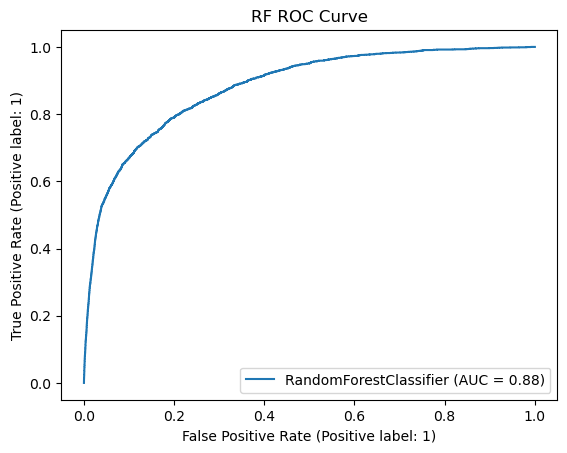

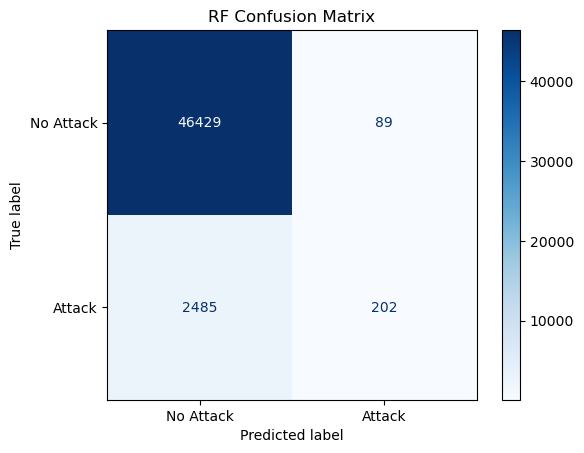

In [7]:

# RF predictions
y_pred_rf  = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# RF metrics
print("Random Forest (tuned)")
print("AUC:     ", roc_auc_score(y_test, y_proba_rf).round(3))
print("Accuracy:", accuracy_score(y_test, y_pred_rf).round(3))
print(classification_report(y_test, y_pred_rf, target_names=['No Attack','Attack']))

# RF ROC & Confusion
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("RF ROC Curve"); plt.show()

ConfusionMatrixDisplay.from_estimator(
    best_rf, X_test, y_test,
    display_labels=['No Attack','Attack'],
    cmap='Blues'
)
plt.title("RF Confusion Matrix"); plt.show()


**XGBoost Results**

XGBoost (baseline)
AUC:      0.882
Accuracy: 0.948
              precision    recall  f1-score   support

   No Attack       0.96      0.99      0.97     46518
      Attack       0.55      0.24      0.33      2687

    accuracy                           0.95     49205
   macro avg       0.75      0.61      0.65     49205
weighted avg       0.93      0.95      0.94     49205



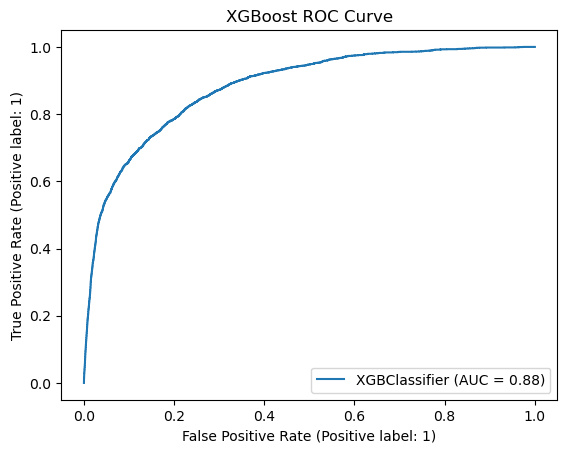

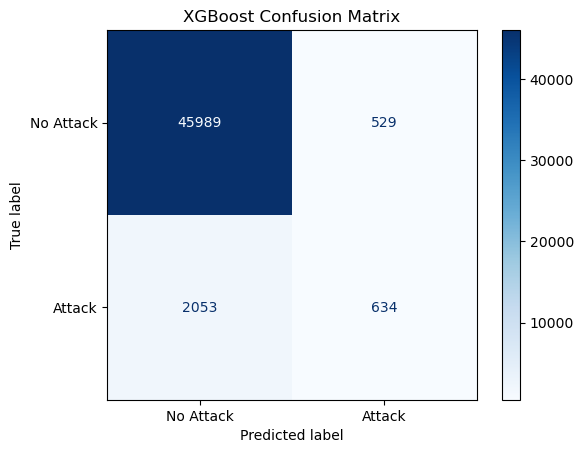

In [8]:
# XGBoost predictions
y_pred_xgb  = xgb_baseline.predict(X_test)
y_proba_xgb = xgb_baseline.predict_proba(X_test)[:, 1]

# XGB metrics
print("XGBoost (baseline)")
print("AUC:     ", roc_auc_score(y_test, y_proba_xgb).round(3))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb).round(3))
print(classification_report(y_test, y_pred_xgb, target_names=['No Attack','Attack']))

# XGB ROC & Confusion
RocCurveDisplay.from_estimator(xgb_baseline, X_test, y_test)
plt.title("XGBoost ROC Curve"); plt.show()

ConfusionMatrixDisplay.from_estimator(
    xgb_baseline, X_test, y_test,
    display_labels=['No Attack','Attack'],
    cmap='Blues'
)
plt.title("XGBoost Confusion Matrix"); plt.show()


Analsyis (so far)

Good overall discrimination (AUC = 0.88)
    This tells us that across all possible thresholds the model can 
    distinguish heart attack and no heart attack
    
Ignore Accuracy, since 5% of our cases are attack, a classifier that always predicts no would get 95% anyway.

Recall tells us what fraction of true “Attack” cases we actually catch.

At the default 0.5 threshold, XGBoost only catches ~24 % of heart‑attack reports; RF catches almost none (~8 %).

Even though RF “precision” is higher (0.69 vs 0.55), that just means when it does predict “Attack,” it’s more often right—but it almost never does.

In [ ]:
**Improved Model From Analysis**

Threshold for ≥80% recall: 0.42

Metrics at tuned threshold:
 Recall:    0.81
 Precision: 0.173
 F1 Score:  0.286


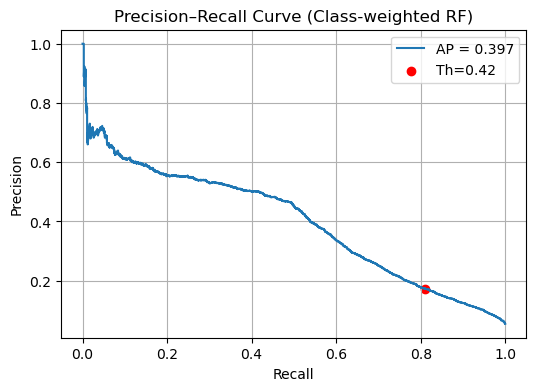

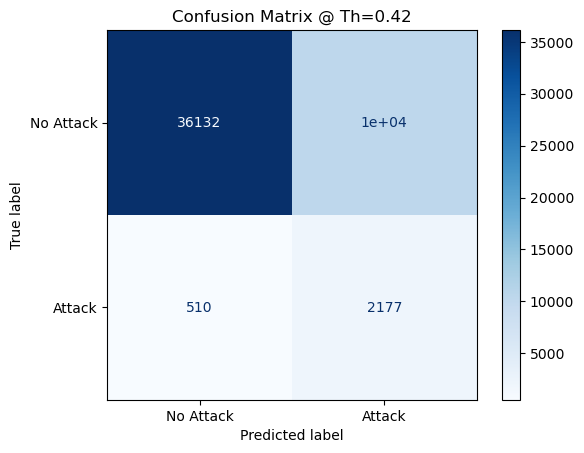

In [22]:
# Retrain RF with class_weight to boost recall
rf_recall = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=2,
    class_weight='balanced',   # <<–– we up the attack weight
    n_jobs=-1,
    random_state=42
)
rf_recall.fit(X_train, y_train)

# Get probabilities on test set
probas = rf_recall.predict_proba(X_test)[:, 1]

# Find the lowest threshold achieving at least 80% recall
target_recall = 0.80
best_thresh = 0.0
for thresh in np.linspace(0, 1, 101)[::-1]:    # ← reverse order
    preds = (probas >= thresh).astype(int)
    if recall_score(y_test, preds) >= target_recall:
        best_thresh = thresh
        break

print(f"Threshold for ≥{int(target_recall*100)}% recall: {best_thresh:.2f}")

# Evaluate at threshold
y_pred_thresh = (probas >= best_thresh).astype(int)
print("\nMetrics at tuned threshold:")
print(" Recall:   ", recall_score(y_test, y_pred_thresh).round(3))
print(" Precision:", precision_score(y_test, y_pred_thresh).round(3))
print(" F1 Score: ", f1_score(y_test, y_pred_thresh).round(3))

# Precision–Recall curve
prec, rec, cut = precision_recall_curve(y_test, probas)
ap = average_precision_score(y_test, probas)

plt.figure(figsize=(6, 4))
plt.plot(rec, prec, label=f'AP = {ap:.3f}')
plt.scatter(
    recall_score(y_test, y_pred_thresh),
    precision_score(y_test, y_pred_thresh),
    color='red', label=f'Th={best_thresh:.2f}'
)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (Class‑weighted RF)')
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_thresh,
    display_labels=['No Attack','Attack'],
    cmap='Blues'
)
plt.title(f'Confusion Matrix @ Th={best_thresh:.2f}')
plt.show()

By moving to a threshold of 0.42 on our weighted random forest, we have raised recall from ~8 % (baseline RF) up to 81 %, at the cost of dropping precision to 17 % vs 69%. The F₁ score sits at 0.29, which is a big jump from the 0.14  –0.33 range we had before at the default cutoff.

So now we have the highest catching or heart attacks however only 17% of our predictions are correct.

NOT GOOD!

We want to get an F1 score > 60%

Now lets try and get the best F1 score (recall-precision balance) using xgboost randomizedsearchCV with hyperparams instead of rf.


Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\kwcoo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:25:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost params for F1: {'subsample': 0.6, 'scale_pos_weight': 17.3119650167473, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 5, 'colsample_bytree': 1.0}
Best F1 = 0.412 at threshold = 0.56

Metrics at best‐F1 threshold:
 Recall:    0.457
 Precision: 0.375
 F1 Score:  0.412


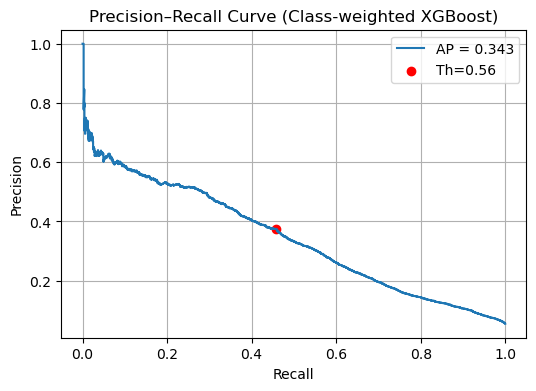

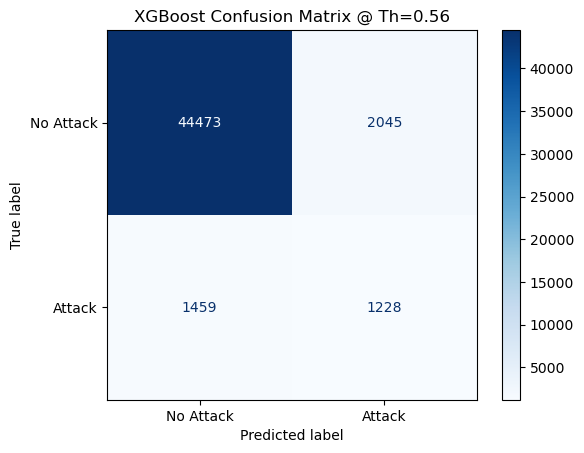

In [30]:
#This is still bad, gonna test some stuff



scale = (y_train == 0).sum() / (y_train == 1).sum()

# Hyperparameter search to maximize F1
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [scale, scale * 2, scale * 5]
}
xgb_search = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring=make_scorer(f1_score),
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
xgb_search.fit(X_train, y_train)

# use the best estimator
xgb_balanced = xgb_search.best_estimator_
print("Best XGBoost params for F1:", xgb_search.best_params_)

# Get probabilities on test set
probas_xgb = xgb_balanced.predict_proba(X_test)[:, 1]

# Find threshold that maximizes F1 (best precision–recall balance)
precisions, recalls, thresholds = precision_recall_curve(y_test, probas_xgb)
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1])
best_idx        = np.nanargmax(f1_scores)
best_thresh_xgb = thresholds[best_idx]
best_f1_xgb     = f1_scores[best_idx]

print(f"Best F1 = {best_f1_xgb:.3f} at threshold = {best_thresh_xgb:.2f}")

# Evaluate at this threshold
y_pred_xgb_thresh = (probas_xgb >= best_thresh_xgb).astype(int)
print("\nMetrics at best‐F1 threshold:")
print(" Recall:   ", recall_score(y_test, y_pred_xgb_thresh).round(3))
print(" Precision:", precision_score(y_test, y_pred_xgb_thresh).round(3))
print(" F1 Score: ", f1_score(y_test, y_pred_xgb_thresh).round(3))

# Precision–Recall curve with best‐F1 point
ap_xgb = average_precision_score(y_test, probas_xgb)
plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label=f'AP = {ap_xgb:.3f}')
plt.scatter(
    recalls[best_idx],
    precisions[best_idx],
    color='red',
    label=f'Th={best_thresh_xgb:.2f}'
)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (Class‑weighted XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix at best‐F1 threshold
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_xgb_thresh,
    display_labels=['No Attack','Attack'],
    cmap='Blues'
)
plt.title(f'XGBoost Confusion Matrix @ Th={best_thresh_xgb:.2f}')
plt.show()

In [31]:
#Testing Log Reg

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

# Train logistic regression with class weighting
logreg = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
logreg.fit(X_train, y_train)


y_proba_lr = logreg.predict_proba(X_test)[:, 1]
y_pred_lr  = (y_proba_lr >= 0.5).astype(int)

print("Logistic Regression")
print("AUC:     ", roc_auc_score(y_test, y_proba_lr).round(3))
print(classification_report(y_test, y_pred_lr, target_names=['No Attack','Attack']))


=== Logistic Regression ===
AUC:      0.885
              precision    recall  f1-score   support

   No Attack       0.98      0.83      0.90     46518
      Attack       0.21      0.76      0.33      2687

    accuracy                           0.83     49205
   macro avg       0.60      0.80      0.62     49205
weighted avg       0.94      0.83      0.87     49205



Best F1 = 0.469 at threshold = 0.81
 Recall:    0.521
 Precision: 0.426
 F1 Score:  0.469


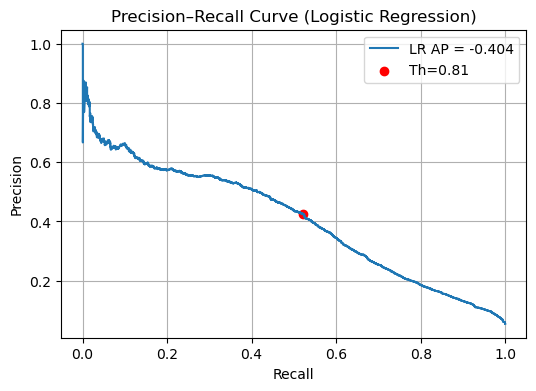

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, recall_score, precision_score

# Get LR probabilities
probas_lr = logreg.predict_proba(X_test)[:,1]

# Compute precision/recall at many thresholds
prec, rec, thresh = precision_recall_curve(y_test, probas_lr)
f1s = 2 * (prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1])
best = np.nanargmax(f1s)
best_thresh_lr, best_f1_lr = thresh[best], f1s[best]

print(f"Best F1 = {best_f1_lr:.3f} at threshold = {best_thresh_lr:.2f}")

# Metrics at that threshold
y_pred_lr_tuned = (probas_lr >= best_thresh_lr).astype(int)
print(" Recall:   ", recall_score(y_test,   y_pred_lr_tuned).round(3))
print(" Precision:", precision_score(y_test, y_pred_lr_tuned).round(3))
print(" F1 Score: ", f1_score(y_test,        y_pred_lr_tuned).round(3))

# PR curve plot
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f'LR AP = {np.trapz(prec, rec):.3f}')
plt.scatter(rec[best], prec[best], color='red', label=f'Th={best_thresh_lr:.2f}')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision–Recall Curve (Logistic Regression)')
plt.legend(); plt.grid(True); plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1','l2'],
    'solver': ['liblinear','saga']
}
gs = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    param_grid,
    scoring=make_scorer(f1_score),
    cv=5, n_jobs=-1
)
gs.fit(X_train, y_train)
print("Best LR params:", gs.best_params_)
